In [ ]:
%cd /content
!pip install torchsde einops diffusers transformers accelerate peft timm kornia aiohttp
!apt install -qqy

!git clone https://github.com/comfyanonymous/ComfyUI /content/ComfyUI
!git clone https://github.com/ltdrdata/ComfyUI-Manager /content/ComfyUI/custom_nodes/ComfyUI-Manager

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/consolidated_s6700.safetensors -d /content/ComfyUI/models/unet -o consolidated_s6700.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_g.safetensors -d /content/ComfyUI/models/clip -o clip_g.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp16.safetensors -d /content/ComfyUI/models/clip -o t5xxl_fp16.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/Long-ViT-L-14-BEST-GmP-smooth-ft.safetensors -d /content/ComfyUI/models/clip -o Long-ViT-L-14-BEST-GmP-smooth-ft.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/ComfyUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/detailed_v2_flux_ntc.safetensors -d /content/ComfyUI/models/loras -o detailed_v2_flux_ntc.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/openflux1-v0.1.0-fast-lora.safetensors -d /content/ComfyUI/models/loras -o openflux1-v0.1.0-fast-lora.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/xlabs_flux_realism_lora_comfui.safetensors -d /content/ComfyUI/models/loras -o xlabs_flux_realism_lora_comfui.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/FLUX.1-Turbo-Alpha.safetensors -d /content/ComfyUI/models/loras -o FLUX.1-Turbo-Alpha.safetensors

In [ ]:
%cd /content/ComfyUI

import os, shutil, json, requests, random, time
from urllib.parse import urlsplit

import torch
from PIL import Image
import numpy as np

from nodes import NODE_CLASS_MAPPINGS, load_custom_node
from comfy_extras import nodes_flux, nodes_model_advanced, nodes_custom_sampler, nodes_sd3

load_custom_node("/content/ComfyUI/custom_nodes/ComfyUI-Adaptive-Guidance")
load_custom_node("/content/ComfyUI/custom_nodes/ComfyUI-Detail-Daemon")

UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
TripleCLIPLoader = nodes_sd3.NODE_CLASS_MAPPINGS["TripleCLIPLoader"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
CLIPVisionLoader = NODE_CLASS_MAPPINGS["CLIPVisionLoader"]()
LoadImage = NODE_CLASS_MAPPINGS["LoadImage"]()
StyleModelLoader =  NODE_CLASS_MAPPINGS["StyleModelLoader"]()
LoraLoader = NODE_CLASS_MAPPINGS["LoraLoader"]()

ModelSamplingFlux = nodes_model_advanced.NODE_CLASS_MAPPINGS["ModelSamplingFlux"]()
CLIPTextEncode = NODE_CLASS_MAPPINGS["CLIPTextEncode"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
AdaptiveGuidance = NODE_CLASS_MAPPINGS["AdaptiveGuidance"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
DetailDaemonSamplerNode = NODE_CLASS_MAPPINGS["DetailDaemonSamplerNode"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()

with torch.inference_mode():
    unet = UNETLoader.load_unet("consolidated_s6700.safetensors", "fp8_e4m3fn")[0]
    clip = TripleCLIPLoader.load_clip("google_t5-v1_1-xxl_encoderonly-fp8_e4m3fn.safetensors", "Long-ViT-L-14-BEST-GmP-smooth-ft.safetensors", "clip_g.safetensors")[0]
    unet1, clip1 = LoraLoader.load_lora(unet, clip, "flux/FLUX.1-Turbo-Alpha.safetensors", 1.00, 1.00)
    unet2, clip2 = LoraLoader.load_lora(unet1, clip1, "flux/openflux1-v0.1.0-fast-lora.safetensors", 0.33, 0.33)
    unet3, clip3 = LoraLoader.load_lora(unet2, clip2, "flux/xlabs_flux_realism_lora_comfui.safetensors", 0.70, 0.70)
    unet4, clip4 = LoraLoader.load_lora(unet3, clip3, "flux/detailed_v2_flux_ntc.safetensors", 0.70, 0.70)
    vae = VAELoader.load_vae("ae.sft")[0]

def download_file(url, save_dir, file_name):
    os.makedirs(save_dir, exist_ok=True)
    file_suffix = os.path.splitext(urlsplit(url).path)[1]
    file_name_with_suffix = file_name + file_suffix
    file_path = os.path.join(save_dir, file_name_with_suffix)
    response = requests.get(url)
    response.raise_for_status()
    with open(file_path, 'wb') as file:
        file.write(response.content)
    return file_path

@torch.inference_mode()
def generate(input):
    values = input["input"]

    positive_prompt = values['positive_prompt']
    negative_prompt = values['negative_prompt']
    enable_custom_lora = values['enable_custom_lora']
    if enable_custom_lora:
        lora_url = values['lora_url']
        lora_file = download_file(url=lora_url, save_dir='/content/ComfyUI/models/loras', file_name='lora_file')
        lora_file = os.path.basename(lora_file)
        lora_strength_model = values['lora_strength_model']
        lora_strength_clip = values['lora_strength_clip']
        unet5, clip5 = LoraLoader.load_lora(unet4, clip4, lora_file, lora_strength_model, lora_strength_clip)
        if os.path.exists('/content/ComfyUI/models/loras/lora_file.safetensors'):
            os.remove('/content/ComfyUI/models/loras/lora_file.safetensors')
    else:
        unet5 = unet4
        clip5 = clip4
    seed = values['seed']
    steps = values['steps']
    cfg = values['cfg']
    sampler_name = values['sampler_name']
    scheduler = values['scheduler']
    max_shift = values['max_shift']
    base_shift = values['base_shift']
    width = values['width']
    height = values['height']

    if seed == 0:
        random.seed(int(time.time()))
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    positive = CLIPTextEncode.encode(clip5, positive_prompt)[0]
    negative = CLIPTextEncode.encode(clip5, negative_prompt)[0]
    unet_flux = ModelSamplingFlux.patch(unet5, max_shift, base_shift, width, height)[0]
    noise = RandomNoise.get_noise(seed)[0]
    guider = AdaptiveGuidance.get_guider(unet_flux, positive, negative, 1.0, cfg, uncond_zero_scale=0.0, cfg_start_pct=0.0)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet_flux, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(width, height)[0]
    sampler = DetailDaemonSamplerNode.go(sampler=sampler, detail_amount=0.2, start=0.2, end=0.9, bias=1.0, exponent=1.0, start_offset=0.0, end_offset=0.0, fade=0.0, smooth=False, cfg_scale_override=0.0)[0]
    samples, _ = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    decoded = VAEDecode.decode(vae, samples)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save(f"/content/flux.1-dev-distill-{seed}-tost.png")

    result = f"/content/flux.1-dev-distill-{seed}-tost.png"

    return result

1


  0%|          | 0/8 [00:00<?, ?it/s]

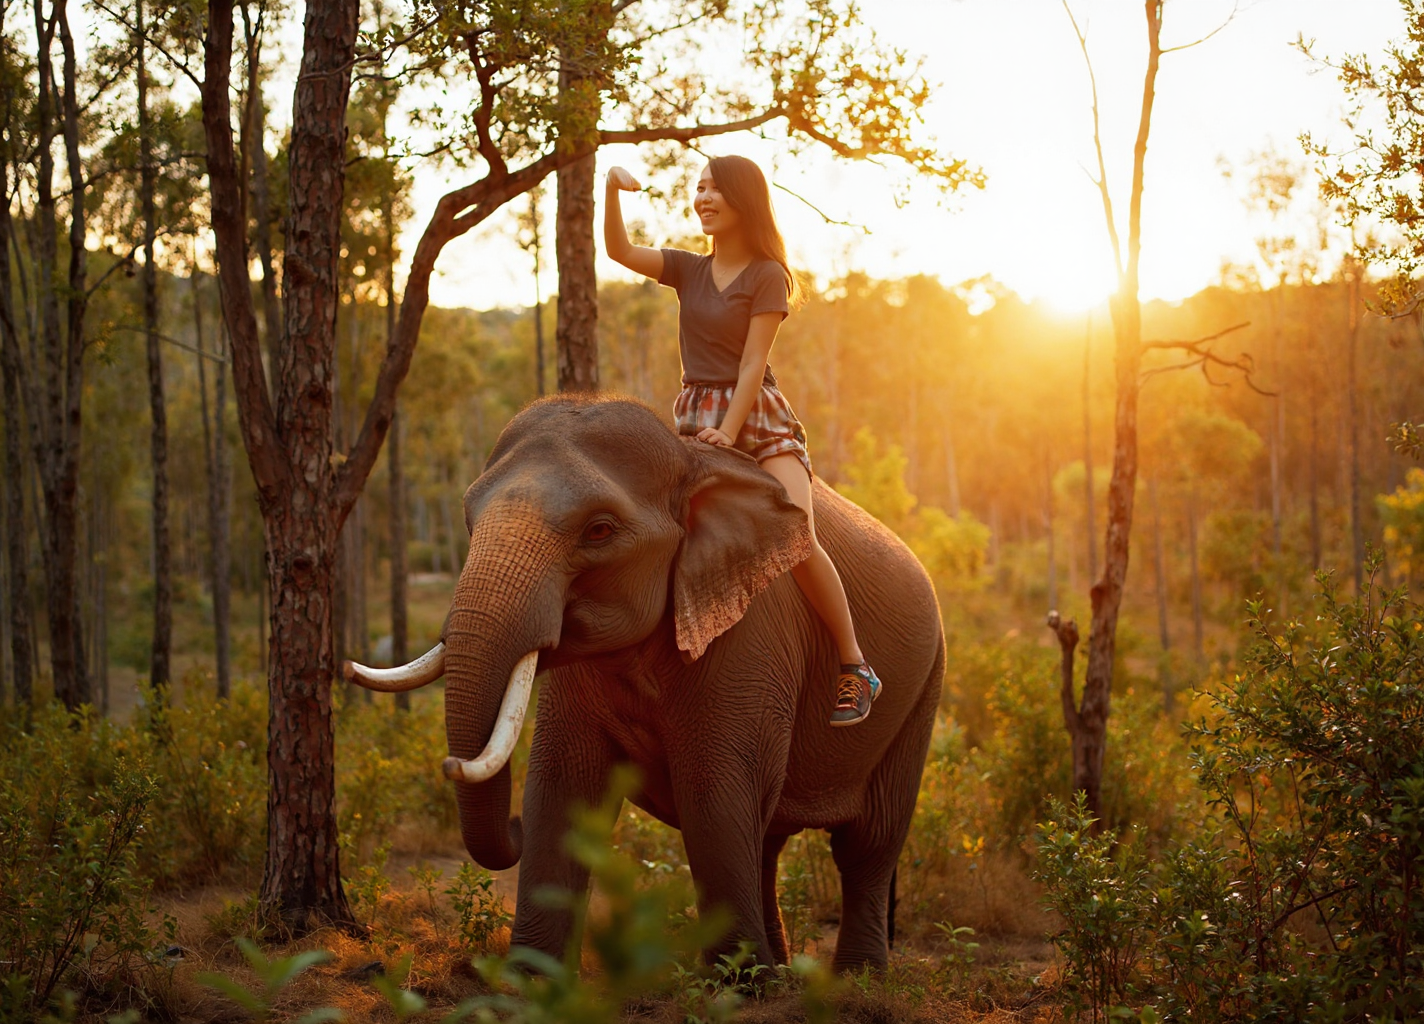

In [3]:
input = { 
        "input": { 
            "positive_prompt": "A close-up photograph of a clay person camper riding a elephant in the forest at golden hour",
            "negative_prompt": "blurry, sharp",
            "enable_custom_lora": True,
            "lora_url": "https://huggingface.co/TostAI/flux-1-dev-lora/resolve/main/8iiu0y.safetensors",
            "lora_strength_model": 1,
            "lora_strength_clip": 1,
            "seed": 0,
            "steps": 8,
            "cfg": 3.5,
            "sampler_name": "euler",
            "scheduler": "beta",
            "max_shift": 1.15,
            "base_shift": 0.50,
            "width": 1024,
            "height": 1024
        }
}
image = generate(input)
Image.open(image)